# AI2 ACE

Example code to plot a AI2 ACE output.

* <https://github.com/ai2cm/ace/>
* see class slides for instructions for running ACE

## Environment
```
conda create --name env-ats780a8 python=3.10
conda activate env-ats780a8
conda install -c conda-forge xarray netCDF4 cartopy
pip install ipykernel
```

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import pickle
import numpy as np

In [2]:
# Open the ACE data
DATA_DIR = "output/"
filename = DATA_DIR + 'autoregressive_predictions.nc'
ds = xr.open_dataset(filename)
ds["lon"] = np.arange(0, 360, 1)  # longitudes are a bit funny, so we need to redefine them
ds

<xarray.Dataset> Size: 83MB
Dimensions:              (time: 40, sample: 4, lat: 180, lon: 360)
Coordinates:
  * time                 (time) timedelta64[ns] 320B 0 days 00:00:00 ... 9 da...
    init_time            (sample) object 32B ...
    valid_time           (sample, time) object 1kB ...
  * lat                  (lat) float32 720B -89.24 -88.25 -87.25 ... 88.25 89.24
  * lon                  (lon) int64 3kB 0 1 2 3 4 5 ... 354 355 356 357 358 359
Dimensions without coordinates: sample
Data variables:
    surface_temperature  (sample, time, lat, lon) float32 41MB ...
    PRATEsfc             (sample, time, lat, lon) float32 41MB ...

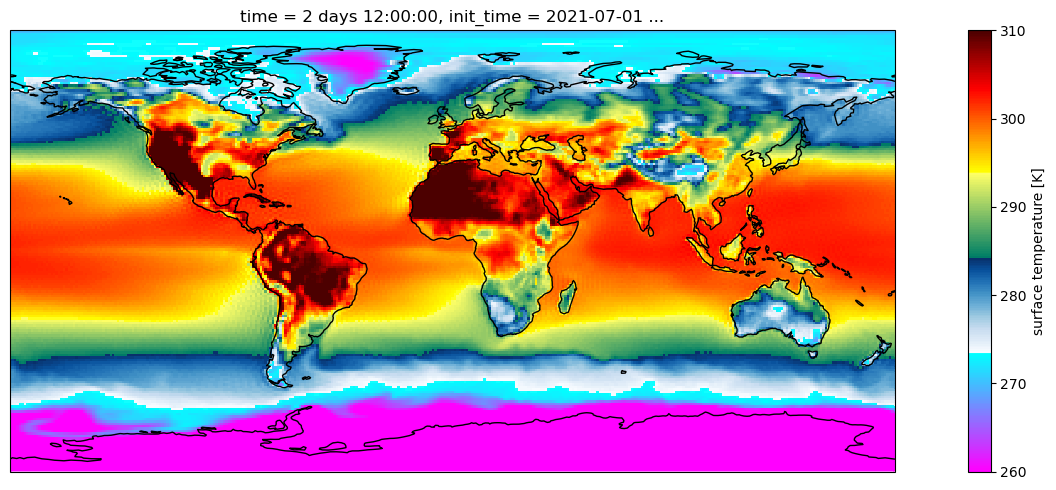

In [3]:
var = "surface_temperature"  # "PRATEsfc"
member = 0  # which member to plot
leadtime = 10  # in increments of 6 hours
#-----------------------------------------
# temperature colormap from pickle
fp = open('../lecture_code/sfc_temp_cmap.pkl', 'rb')
sfc_temp_cmap = pickle.load(fp)
fp.close()

# create 500avo colormap
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 36))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors_500avo = np.vstack((colors2, (1, 1, 1, 1), colors1))
colors_500avo = plt.cm.colors.ListedColormap(np.vstack((colors2, (1, 1, 1, 1), colors1)))

# Plot and compare the models
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

img = ds[var][member,leadtime,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=sfc_temp_cmap)
if var == "surface_temperature":
    img.set_clim(260, 310)
else:
    img.set_cmap("Blues")
    img.set_clim(0, 0.0005)

# Add coastlines and gridlines
ax.coastlines()

plt.tight_layout()
plt.show()

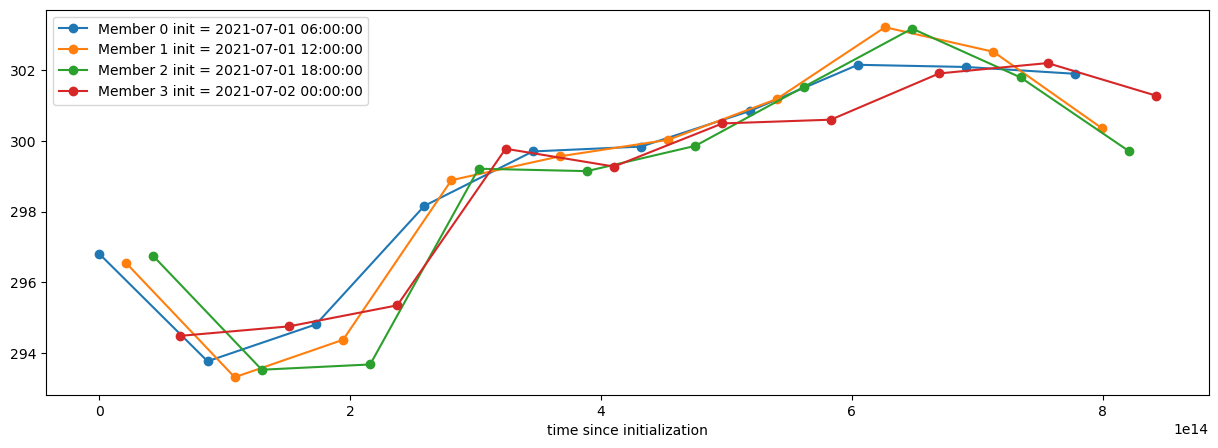

In [4]:
# Define the target latitude and longitude
target_lat = 40.5853
target_lon = 360-105.0844

# Compare forecasts at the target point for all AI models
plt.figure(figsize=(15, 5))
for member in ds["sample"].to_numpy():
    nearest_point = ds[var].sel(lat=target_lat, lon=target_lon, method='nearest')
    daily_mean = nearest_point[member, :].resample(time='1D').mean()

    time_shift = np.timedelta64(ds[var][member]['init_time'].values - ds[var][0]['init_time'].values)

    plt.plot(daily_mean['time'] + time_shift, daily_mean, "o-", label=f"Member {member} init = {daily_mean['init_time'].values}")

# Modify the title
plt.xlabel("time since initialization")
plt.legend()